## Load and train model 

In [1]:
import pandas as pd 
from datetime import datetime  
from load_DataSet_subway_15 import load_normalized_dataset
from DL_utilities import DictDataLoader,Trainer,PI_object,QuantileLoss,load_model,get_loss,choose_optimizer,get_dic_results
from PI import DeepEnsemble,plot_bands_CQR,plot_uncertainty_bands,plot_conformal_bands,plot_DQR
from calendar_class import get_time_slots_labels
from load_adj import load_adj
import numpy as np 
import os 
import sys
import torch
import torch.nn as nn
from torch.optim import SGD,Adam,AdamW
import random


try:
    from plotting import plot_loss
    import matplotlib.pyplot as plt 
except : 
    print('matplotlib.pyplot is not available')

notebook_dir = os.getcwd()
code_dir = os.path.abspath(os.path.join(notebook_dir, '../'))
if code_dir not in sys.path:
    sys.path.insert(0,code_dir)

# Import models : 
from dl_models.CNN_based_model import CNN
from dl_models.MTGNN import gtnet
from dl_models.RNN_based_model import RNN
from dl_models.STGCN import STGCNChebGraphConv, STGCNGraphConv
from dl_models.STGCN_utilities import calc_chebynet_gso,calc_gso

# Import config
from config import get_config,get_parameters

# Paths
folder_path = 'data/'
file_name = 'preprocessed_subway_15_min.csv'

#Init and load data: 
time_step_per_hour=4
H,W,D = 6,1,1
L = H+W+D 
step_ahead = 1

window_pred = np.arange(2*96)

# Load subway in data:
subway_in = pd.read_csv(folder_path+file_name,index_col = 0)
subway_in.columns.name = 'Station'
subway_in.index = pd.to_datetime(subway_in.index)

# Invalid dates : 
invalid_dates = pd.date_range(datetime(2019,4,23,14),datetime(2019,4,28,14),freq = f'{60/time_step_per_hour}min')

## Load and train model 

In [2]:
def load_train_calib_model(args,args_embedding):
    # load data model 
    print(f"Type of model: {args.model_name} \n Loss function type: {args.loss_function_type} \n Quantile Method : {args.quantile_method} \n Calendar Class: {args.calendar_class} \n")
    (dataset,U,Utarget) = load_normalized_dataset(subway_in,time_step_per_hour,args.train_prop,step_ahead,H,D,W,invalid_dates)
    time_slots_labels,dic_class2rpz,dic_rpz2class = get_time_slots_labels(dataset,type_class= args.calendar_class)
    data_loader_obj = DictDataLoader(U,Utarget,args.train_prop,args.valid_prop,validation = 'classic', shuffle = True, calib_prop=args.calib_prop, time_slots = time_slots_labels)
    data_loader = data_loader_obj.get_dictdataloader(args.batch_size)

    # Quantile Loss
    quantiles = torch.Tensor([args.alpha/2,1-args.alpha/2]).to(args.device)
    assert args.out_dim == len(quantiles), "Output dimension doesn't match with the number of estimated quantiles"
    loss_function = get_loss(args.loss_function_type,quantiles)

    # Load model : 
    model = load_model(args,args_embedding)
    model.to(args.device)
    optimizer = choose_optimizer(model,args)

    trainer = Trainer(model,data_loader,args,optimizer,loss_function,scheduler = None,args_embedding = args_embedding)  # Ajoute dans trainer, if calibration_prop is not None .... et on modifie le dataloader en ajoutant un clabration set
    trainer.train_and_valid(mod = 1000)  # Récupère les conformity scores sur I1, avec les estimations faites precedemment 
    Q = trainer.conformal_calibration(args.alpha,dataset,conformity_scores_type =args.conformity_scores_type, quantile_method = args.quantile_method)  # calibration for PI 90%
      
    (preds,Y_true,T_labels,df_metrics) = trainer.testing(dataset,metrics= ['mse','mae'])

    return(dataset,trainer,Q,preds,Y_true,T_labels)

### Time Embedding args : 

In [19]:
Encoded_dims = [4,24,7]
embedding_dim = 2

config_Tembed = dict(Encoded_dims=  [Encoded_dims],embedding_dim = embedding_dim,position='input')
args_embedding = get_parameters(config_Tembed,description = 'TimeEmbedding')

In [20]:
# Choose Model 
config = get_config(model_name = 'CNN')

# Load config
config['conformity_scores_type'] = 'max_residual' 
config['seq_length'] = L

args = get_parameters(config)
args.epochs = 30
args_embedding.position = 'input'   #concat for output
print(f"Type of model: {args.model_name} \n Loss function type: {args.loss_function_type} \n Quantile Method : {args.quantile_method} \n Calendar Class: {args.calendar_class} \n")
# ...

# Load dataset, dataloader, loss function, Model, Optimizer, Trainer 
(dataset,U,Utarget) = load_normalized_dataset(subway_in,time_step_per_hour,args.train_prop,step_ahead,H,D,W,invalid_dates)
time_slots_labels,dic_class2rpz,dic_rpz2class = get_time_slots_labels(dataset,type_class= args.calendar_class)
data_loader_obj = DictDataLoader(U,Utarget,args.train_prop,args.valid_prop,validation = 'classic', shuffle = True, calib_prop=args.calib_prop, time_slots = time_slots_labels)
data_loader = data_loader_obj.get_dictdataloader(args.batch_size)

# Quantile Loss
quantiles = torch.Tensor([args.alpha/2,1-args.alpha/2]).to(args.device)
assert args.out_dim == len(quantiles), "Output dimension doesn't match with the number of estimated quantiles"
loss_function = get_loss(args.loss_function_type,quantiles)

Type of model: CNN 
 Loss function type: quantile 
 Quantile Method : weekday_hour 
 Calendar Class: 2 



start training
epoch: 0 
 min\epoch : 0.01
Estimated time for training: 0.2min 


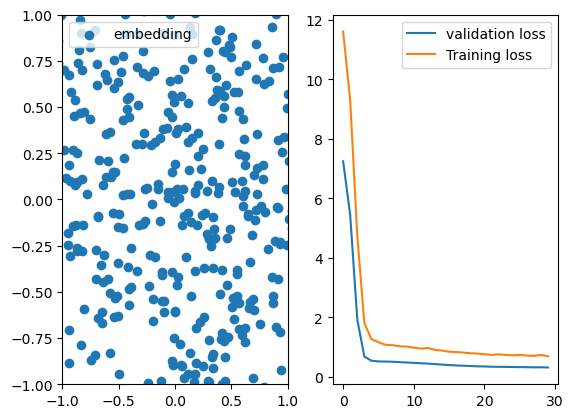

start training
epoch: 0 
 min\epoch : 0.01
Estimated time for training: 0.2min 


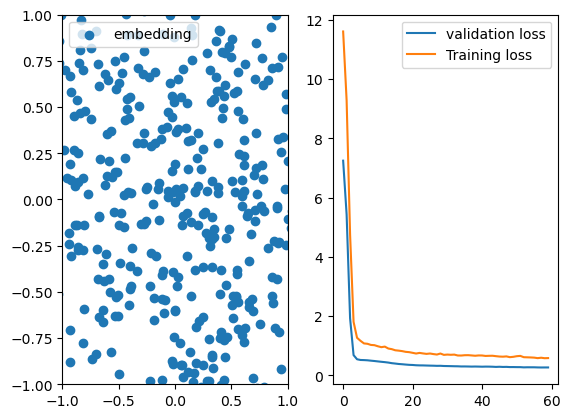

start training
epoch: 0 
 min\epoch : 0.01
Estimated time for training: 0.2min 


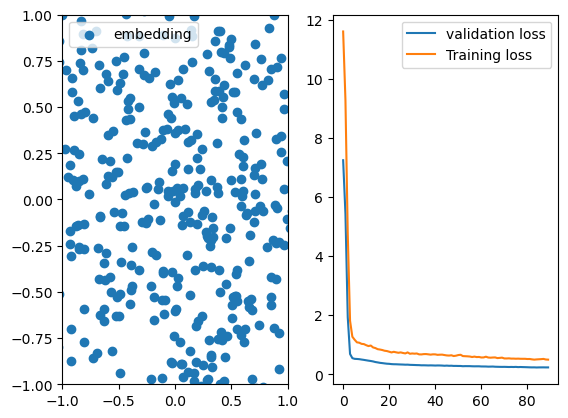

start training
epoch: 0 
 min\epoch : 0.01
Estimated time for training: 0.2min 


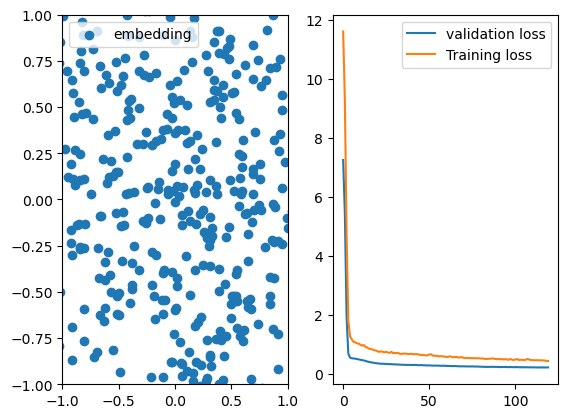

start training
epoch: 0 
 min\epoch : 0.01
Estimated time for training: 0.2min 


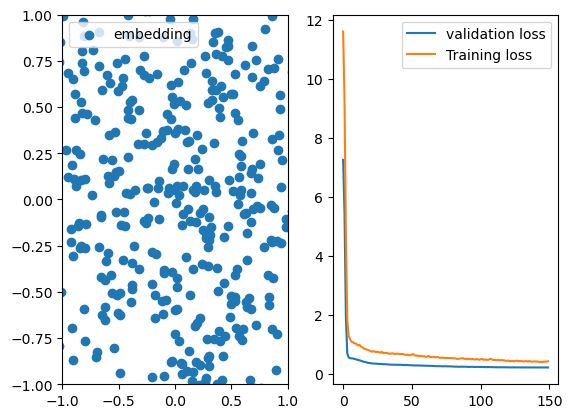

start training
epoch: 0 
 min\epoch : 0.01
Estimated time for training: 0.2min 


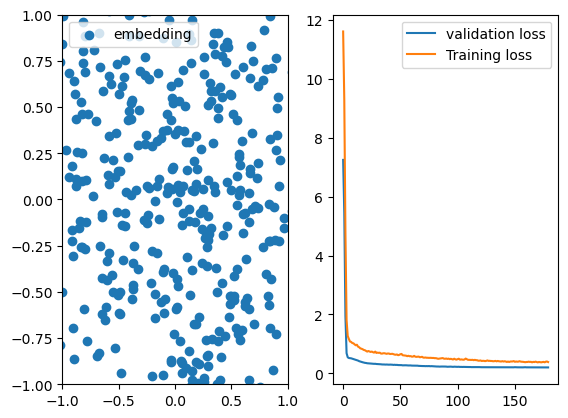

start training
epoch: 0 
 min\epoch : 0.01
Estimated time for training: 0.2min 


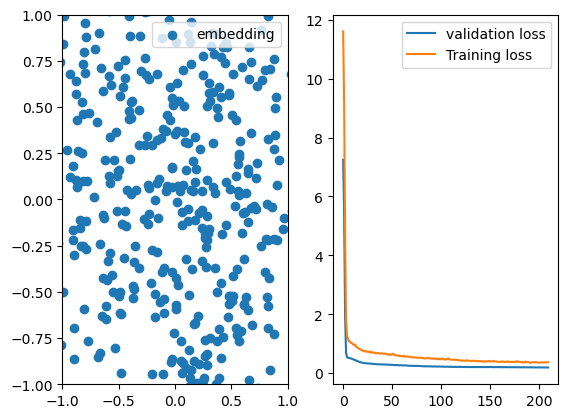

start training
epoch: 0 
 min\epoch : 0.01
Estimated time for training: 0.2min 


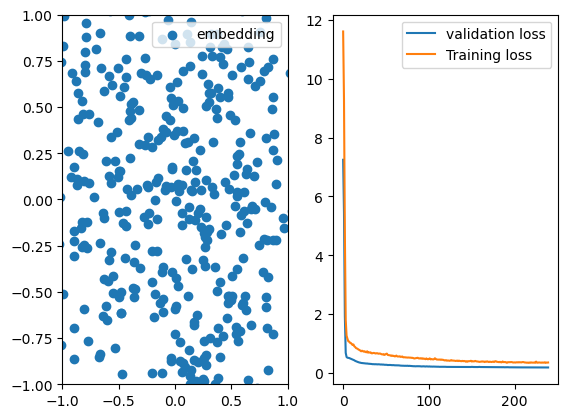

start training
epoch: 0 
 min\epoch : 0.01
Estimated time for training: 0.2min 


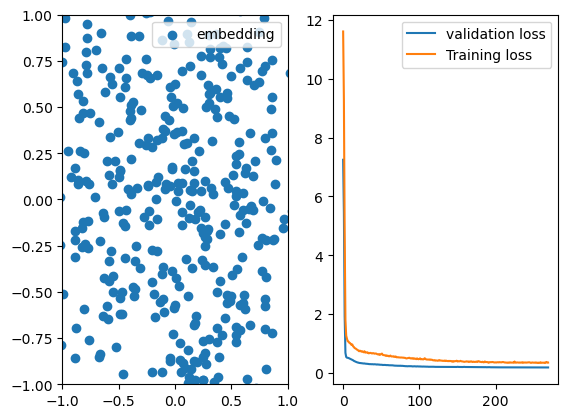

start training
epoch: 0 
 min\epoch : 0.01
Estimated time for training: 0.2min 


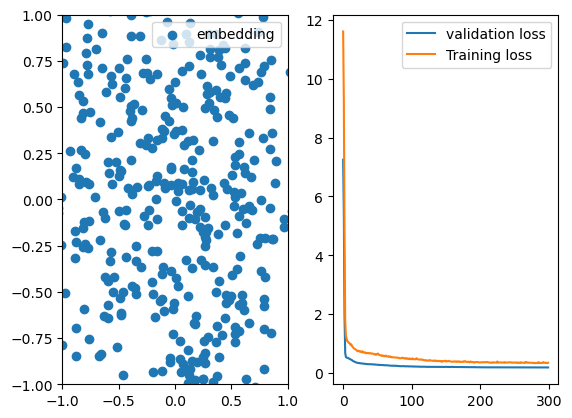

start training
epoch: 0 
 min\epoch : 0.01
Estimated time for training: 0.2min 


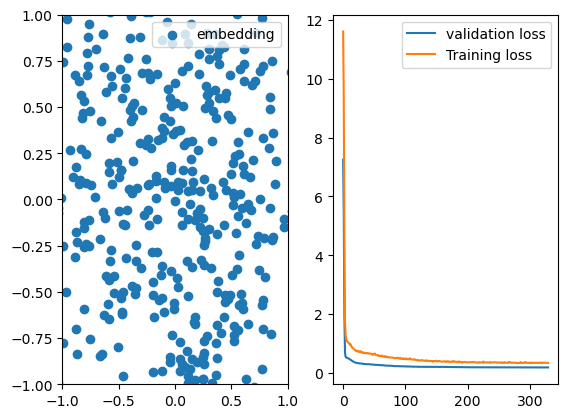

start training
epoch: 0 
 min\epoch : 0.01
Estimated time for training: 0.2min 


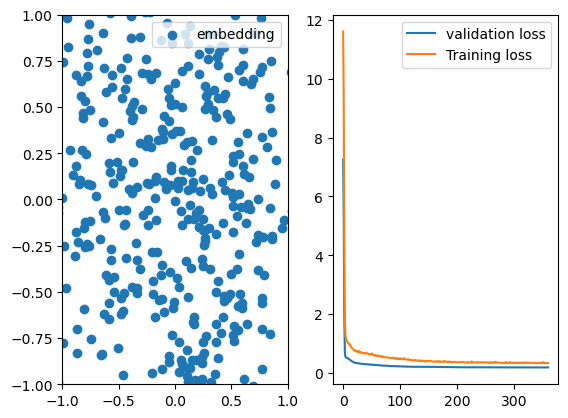

start training
epoch: 0 
 min\epoch : 0.01
Estimated time for training: 0.2min 


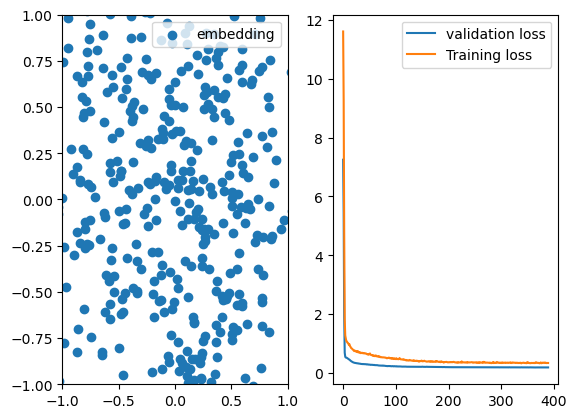

start training
epoch: 0 
 min\epoch : 0.01
Estimated time for training: 0.2min 


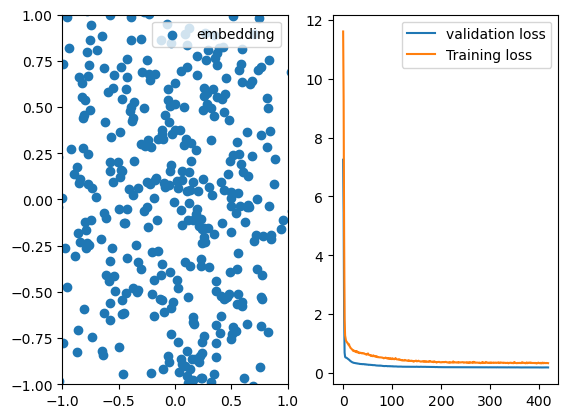

start training
epoch: 0 
 min\epoch : 0.01
Estimated time for training: 0.2min 


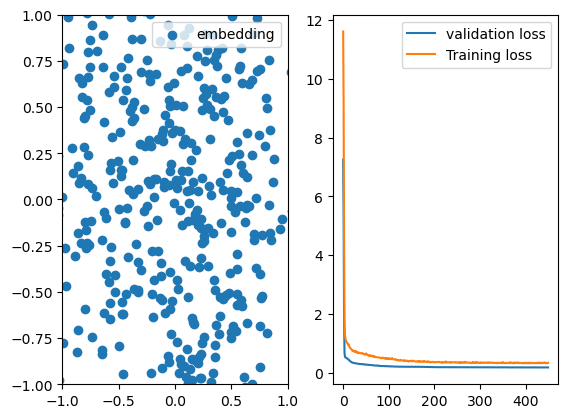

start training
epoch: 0 
 min\epoch : 0.01
Estimated time for training: 0.2min 


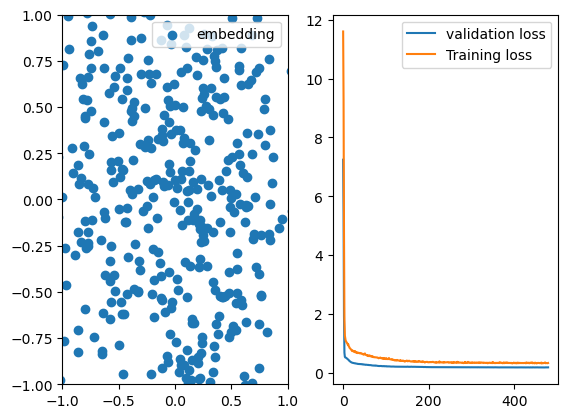

start training
epoch: 0 
 min\epoch : 0.01
Estimated time for training: 0.2min 


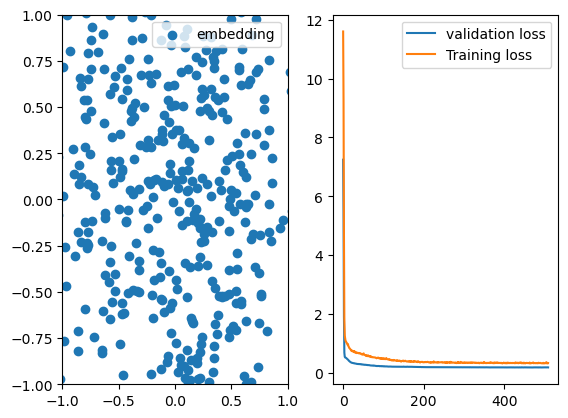

start training
epoch: 0 
 min\epoch : 0.01
Estimated time for training: 0.2min 


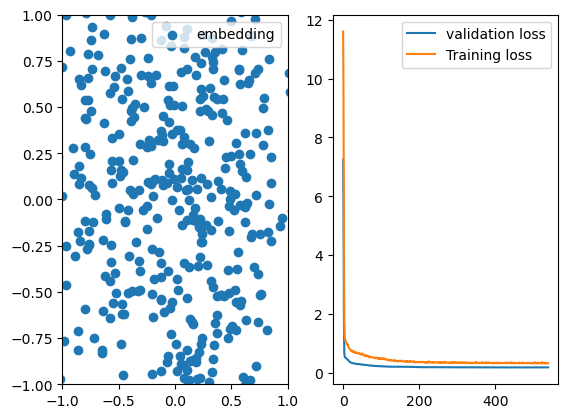

start training
epoch: 0 
 min\epoch : 0.01
Estimated time for training: 0.2min 


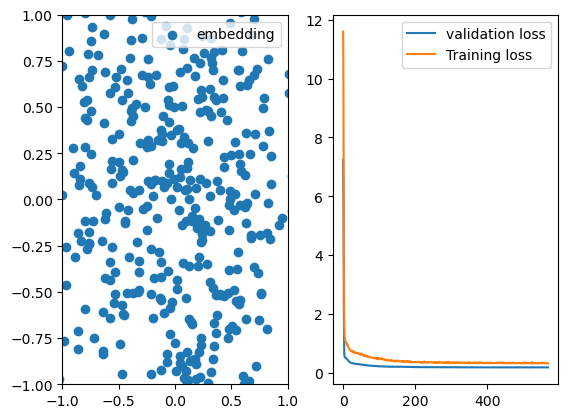

start training
epoch: 0 
 min\epoch : 0.01
Estimated time for training: 0.2min 


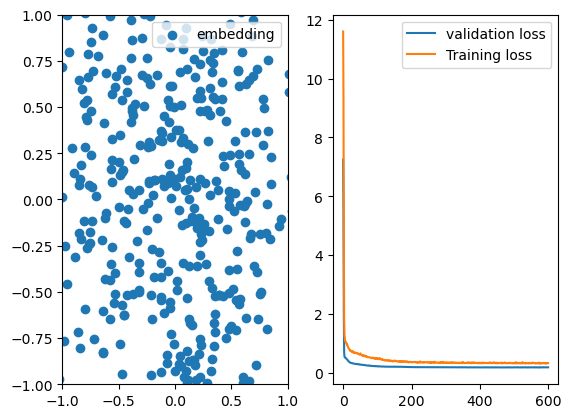

In [26]:
model = load_model(args,args_embedding)
model.to(args.device)
optimizer = choose_optimizer(model,args)
trainer = Trainer(model,data_loader,args,optimizer,loss_function,scheduler = None,args_embedding = args_embedding)  # Ajoute dans trainer, if calibration_prop is not None .... et on modifie le dataloader en ajoutant un clabration set
# ...

# Train and plot : 
for nb_visu in range(20):
    trainer.train_and_valid(mod = 1000)  # Récupère les conformity scores sur I1, avec les estimations faites precedemment 
    #T_labels_cal = torch.cat([t_b for _,_,t_b in data_loader['train']])  # T_labels issus de la calibration  
    trainer.model.eval()   # pas grad, pas de dropout 
    with torch.no_grad():
        #output = trainer.model.Tembedding(T_labels_cal.long())
        output = trainer.model.Tembedding(torch.arange(672).long().to(args.device))

    # Plot 3D: 
    # X1,Y1,Z1 = output[:,0].numpy(),output[:,1].numpy(),output[:,2].numpy()
    # ax = plt.figure().add_subplot(projection='3d')
    # ax.scatter(X1,Y1,Z1,label = 'embedding')
    # ...

    # PLot 2D: 
    X1,Y1 = output[:,0].cpu().numpy(),output[:,1].cpu().numpy()
    fig, (ax1,ax2) = plt.subplots(1,2)
    ax1.scatter(X1,Y1,label = 'embedding')
    ax1.set_xlim([-1,1])
    ax1.set_ylim([-1,1])
    ax1.legend()

    ax2.plot(np.arange(len(trainer.valid_loss)),trainer.valid_loss,label = 'validation loss')
    ax2.plot(np.arange(len(trainer.valid_loss)),trainer.train_loss,label = 'Training loss')
    ax2.legend()
    plt.show()

In [9]:
config = get_config(model_name = 'CNN')

config['conformity_scores_type'] = 'max_residual' 
config['seq_length'] = L

args = get_parameters(config)
args.epochs = 100

# Load train and calib model 
print(f"Type of model: {args.model_name} \n Loss function type: {args.loss_function_type} \n Quantile Method : {args.quantile_method} \n Calendar Class: {args.calendar_class} \n")
(dataset,U,Utarget) = load_normalized_dataset(subway_in,time_step_per_hour,args.train_prop,step_ahead,H,D,W,invalid_dates)
time_slots_labels,dic_class2rpz,dic_rpz2class = get_time_slots_labels(dataset,type_class= args.calendar_class)
data_loader_obj = DictDataLoader(U,Utarget,args.train_prop,args.valid_prop,validation = 'classic', shuffle = True, calib_prop=args.calib_prop, time_slots = time_slots_labels)
data_loader = data_loader_obj.get_dictdataloader(args.batch_size)

# Quantile Loss
quantiles = torch.Tensor([args.alpha/2,1-args.alpha/2]).to(args.device)
assert args.out_dim == len(quantiles), "Output dimension doesn't match with the number of estimated quantiles"
loss_function = get_loss(args.loss_function_type,quantiles)

# Load model : 
model = load_model(args,args_embedding)
model.to(args.device)
optimizer = choose_optimizer(model,args)

trainer = Trainer(model,data_loader,args,optimizer,loss_function,scheduler = None,args_embedding = args_embedding)  # Ajoute dans trainer, if calibration_prop is not None .... et on modifie le dataloader en ajoutant un clabration set
trainer.train_and_valid(mod = 1000)  # Récupère les conformity scores sur I1, avec les estimations faites precedemment 
Q = trainer.conformal_calibration(args.alpha,dataset,conformity_scores_type =args.conformity_scores_type, quantile_method = args.quantile_method)  # calibration for PI 90%
    
(preds,Y_true,T_labels,df_metrics) = trainer.testing(dataset,metrics= ['mse','mae'])
# ...


pi = trainer.CQR_PI(preds,Y_true,args.alpha,Q,T_labels.long())
results = get_dic_results(trainer,pi)

conformity_scores = trainer.conformity_scores
plot_bands_CQR(trainer,Y_true,preds,pi,window_pred,args.alpha,conformity_scores,results,bins = 100)

Type of model: CNN 
 Loss function type: quantile 
 Quantile Method : weekday_hour 
 Calendar Class: 2 

start training
epoch: 0 
 min\epoch : 0.01
Estimated time for training: 0.7min 
label 0.0 has only 3 elements in his class. We then use quantile order = 1
label 1.0 has only 2 elements in his class. We then use quantile order = 1
label 2.0 has only 2 elements in his class. We then use quantile order = 1
label 3.0 has only 3 elements in his class. We then use quantile order = 1
label 4.0 has only 5 elements in his class. We then use quantile order = 1
label 5.0 has only 1 elements in his class. We then use quantile order = 1
label 6.0 has only 4 elements in his class. We then use quantile order = 1
label 7.0 has only 2 elements in his class. We then use quantile order = 1
label 8.0 has only 2 elements in his class. We then use quantile order = 1
label 9.0 has only 1 elements in his class. We then use quantile order = 1
label 10.0 has only 3 elements in his class. We then use quantile

/Users/romainrochas/opt/anaconda3/envs/preprocessingclone/lib/python3.7/site-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([1133, 40, 1])) that is different to the input size (torch.Size([1133, 40, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/romainrochas/opt/anaconda3/envs/preprocessingclone/lib/python3.7/site-packages/torch/nn/modules/loss.py:94: UserWarning: Using a target size (torch.Size([1133, 40, 1])) that is different to the input size (torch.Size([1133, 40, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


KeyError: 17

## Load Model 

In [8]:
nb_trial = 1

for _ in range(nb_trial):
    config = get_config(model_name = 'CNN')

    config['conformity_scores_type'] = 'max_residual' 
    config['seq_length'] = L

    args = get_parameters(config)
    args.epochs = 100

    dataset,trainer,Q,preds,Y_true,T_labels = load_train_calib_model(args,args_embedding)
    pi = trainer.CQR_PI(preds,Y_true,args.alpha,Q,T_labels.long())
    results = get_dic_results(trainer,pi)

    conformity_scores = trainer.conformity_scores
    plot_bands_CQR(trainer,Y_true,preds,pi,window_pred,args.alpha,conformity_scores,results,bins = 100)

Type of model: CNN 
 Loss function type: quantile 
 Quantile Method : weekday_hour 
 Calendar Class: 2 

start training
epoch: 0 
 min\epoch : 0.01
Estimated time for training: 0.7min 
label 0.0 has only 3 elements in his class. We then use quantile order = 1
label 1.0 has only 5 elements in his class. We then use quantile order = 1
label 2.0 has only 3 elements in his class. We then use quantile order = 1
label 3.0 has only 4 elements in his class. We then use quantile order = 1
label 4.0 has only 5 elements in his class. We then use quantile order = 1
label 5.0 has only 3 elements in his class. We then use quantile order = 1
label 6.0 has only 2 elements in his class. We then use quantile order = 1
label 7.0 has only 1 elements in his class. We then use quantile order = 1
label 8.0 has only 4 elements in his class. We then use quantile order = 1
label 9.0 has only 3 elements in his class. We then use quantile order = 1
label 10.0 has only 1 elements in his class. We then use quantile

/Users/romainrochas/opt/anaconda3/envs/preprocessingclone/lib/python3.7/site-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([1133, 40, 1])) that is different to the input size (torch.Size([1133, 40, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/romainrochas/opt/anaconda3/envs/preprocessingclone/lib/python3.7/site-packages/torch/nn/modules/loss.py:94: UserWarning: Using a target size (torch.Size([1133, 40, 1])) that is different to the input size (torch.Size([1133, 40, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


KeyError: 50

## Visu pour clustering 

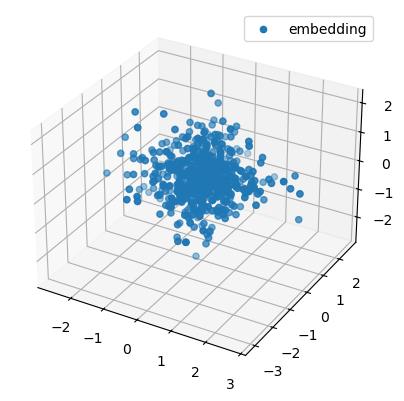

In [65]:
T_labels  # T_labels issus du Training 
trainer.model.eval()   # pas grad, pas de dropout 
with torch.no_grad():
    output = trainer.model.Tembedding(T_labels.long())

X1,Y1,Z1 = output[:,0].numpy(),output[:,1].numpy(),output[:,2].numpy()

x = np.arange(len(X1))
ax = plt.figure().add_subplot(projection='3d')
ax.scatter(X1,Y1,Z1,label = 'embedding')
ax.legend()
plt.show()

180.93881225585938 0.955689063266307
143.93115234375 0.8975600784698382


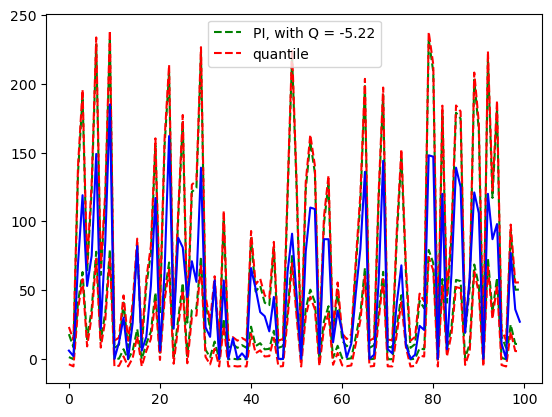

In [4]:
for training_mode in ['cal','train','validate','test']:
    print(training_mode)
    Pred_cal,Y_true_cal =trainer.test_prediction(allow_dropout = False,training_mode = 'cal')
    unorm_Pred_cal,unorm_Y_true_cal = dataset.unormalize_tensor(Pred_cal),dataset.unormalize_tensor(Y_true_cal)

    # PI 'classic' :
    pi_cal = PI_object(unorm_Pred_cal,unorm_Y_true_cal,alpha = args.alpha, type_calib = 'classic')
    print(pi_cal.mpiw,pi_cal.picp)

    # PI 'CQR' : 
    pi_cqr_cal = PI_object(unorm_Pred_cal,unorm_Y_true_cal,alpha = args.alpha, Q = Q, type_calib = 'CQR')
    print(pi_cqr_cal.mpiw,pi_cqr_cal.picp)

    plt.plot(np.arange(100),pi_cqr_cal.upper[:100,0,0],color = 'green',linestyle = 'dashed',label = f"PI, with Q = {'{:.2f}'.format(pi_cqr_cal.Q[0,0,0].item())}")
    plt.plot(np.arange(100),pi_cqr_cal.lower[:100,0,0],color = 'green',linestyle = 'dashed')
    plt.plot(np.arange(100),pi_cal.upper[:100,0,0],color = 'red',linestyle = 'dashed',label = 'quantile')
    plt.plot(np.arange(100),pi_cal.lower[:100,0,0],color = 'red',linestyle = 'dashed')
    plt.plot(np.arange(100),unorm_Y_true_cal[:100,0,0],color = 'blue')
    plt.legend()

In [14]:
# PI des quantiles est trop large (97%). Donc, Q devrait être négatif 
model = trainer.model
model.eval()
with torch.no_grad():
    data = [[x_b,y_b] for  x_b,y_b in trainer.dataloader['cal']]
    X_cal,Y_cal = torch.cat([x_b for [x_b,y_b] in data]),torch.cat([y_b for [x_b,y_b] in data])
    preds = model(X_cal) # x_cal is normalized

    # get lower and upper band
    if preds.size(-1) == 2:
        lower_q,upper_q = preds[...,0].unsqueeze(-1),preds[...,1].unsqueeze(-1)   # The Model return ^q_l and ^q_u associated to x_b

    elif preds.size(-1) == 1:
        lower_q,upper_q = preds,preds 
    else:
        raise ValueError(f"Shape of model's prediction: {preds.size()}. Last dimension should be 1 or 2.")
    
    # unormalized lower band, upper band, and Y_cal 
    lower_q, upper_q = dataset.unormalize_tensor(lower_q),dataset.unormalize_tensor(upper_q)
    Y_cal = dataset.unormalize_tensor(Y_cal)

    # Confority scores and quantiles
    if args.conformity_scores_type == 'max_residual':
        conformity_scores = torch.max(lower_q-Y_cal,Y_cal-upper_q) # Element-wise maximum        #'max(lower_q-y_b,y_b-upper_q)' is the quantile regression error function
    if args.conformity_scores_type == 'max_residual_plus_middle':
        print("|!| Conformity scores computation is not based on 'max(ql-y, y-qu)'")
        conformity_scores = torch.max(lower_q-Y_cal,Y_cal-upper_q) + ((lower_q>Y_cal)(upper_q<Y_cal))*(upper_q - lower_q)/2  # Element-wise maximum        #'max(lower_q-y_b,y_b-upper_q)' is the quantile regression error function 

    quantile_order = torch.Tensor([np.ceil((1 - args.alpha)*(X_cal.size(0)+1))/X_cal.size(0)])
    Q = torch.quantile(conformity_scores, quantile_order, dim = 0) #interpolation = 'higher'

In [15]:
lower_q[:10,0,0],upper_q[:10,0,0],Y_cal[:10,0,0]

(tensor([ 27.0295,   2.3823, -10.6389, -11.9061, -11.9061,  -8.5437,  33.5009,
          41.8354,  46.4636, -12.4527]),
 tensor([177.8735,  67.0889,  53.7768,  37.4192,  37.4192,  36.1508, 213.2399,
         254.6087, 287.3973,  38.0547]),
 tensor([124.,  27.,  39.,   0.,   0.,  31., 109., 106., 121.,   4.]))

0.36081740260124207 0.9917475728155339


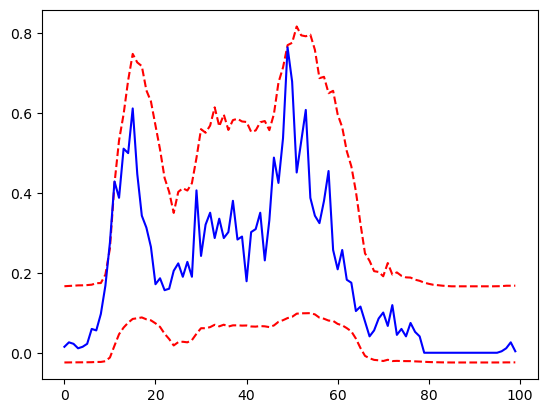

In [12]:
Pred_test,Y_true_test =trainer.test_prediction(allow_dropout = False,training_mode = 'test')
pi_test = PI_object(Pred_test,Y_true_test,alpha = args.alpha, type_calib = 'classic')
print(pi_test.mpiw,pi_test.picp)

plt.plot(np.arange(100),Pred_test[:100,0,0],color = 'red',linestyle = 'dashed')
plt.plot(np.arange(100),Pred_test[:100,0,1],color = 'red',linestyle = 'dashed')
plt.plot(np.arange(100),Y_true_test[:100,0,0],color = 'blue')

0.34379279613494873 0.9918358340688438


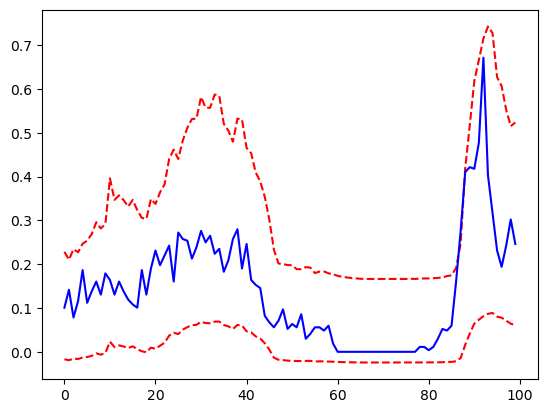

In [14]:
Pred_valid,Y_true_valid =trainer.test_prediction(allow_dropout = False,training_mode = 'validate')
pi_valid = PI_object(Pred_valid,Y_true_valid,alpha = args.alpha, type_calib = 'classic')
print(pi_valid.mpiw,pi_valid.picp)

plt.plot(np.arange(100),Pred_valid[:100,0,0],color = 'red',linestyle = 'dashed')
plt.plot(np.arange(100),Pred_valid[:100,0,1],color = 'red',linestyle = 'dashed')
plt.plot(np.arange(100),Y_true_valid[:100,0,0],color = 'blue')

0.34810584783554077 0.9901325478645067


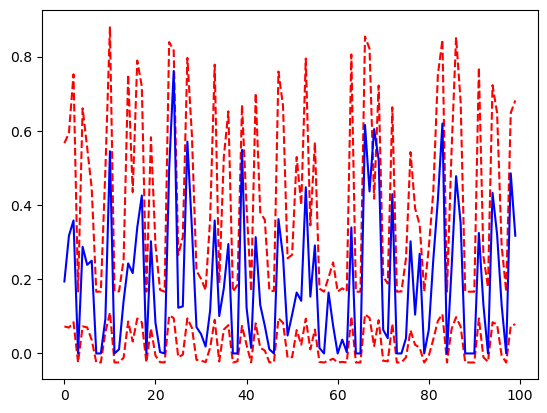

In [23]:
Pred_train,Y_true_train =trainer.test_prediction(allow_dropout = False,training_mode = 'train')
pi_train = PI_object(Pred_train,Y_true_train,alpha = args.alpha, type_calib = 'classic')
print(pi_train.mpiw,pi_train.picp)

plt.plot(np.arange(100),Pred_train[:100,0,0],color = 'red',linestyle = 'dashed')
plt.plot(np.arange(100),Pred_train[:100,0,1],color = 'red',linestyle = 'dashed')
plt.plot(np.arange(100),Y_true_train[:100,0,0],color = 'blue')

A priori, ça ne sert à rien de les projeté dans un espace de plus grande dimension.
- J'ai un ensemble de 'mot'. Chaque mot correspond a une combinaison (d,h,m).
- Il y a 7 jours, 24h, 4 time-step de minute (0,15,30,45). Donc j'ai un ensemble de 4*7*24 = 672 mots.
- J'aimerais faire un embedding de ces mots. C'est a dire représenter chaque mot par un vecteur. 

Exemple : 
(0,7,0) est 'Lundi 8h15'. J'en fais un embedding (donc une projection) dans un espace latent (exemple en dimension 3):


**Problème** : très peu d'occurence de chacun des 'mots' (En tout une semaine pour balayer une seule fois chaucn des mots possible. Donc 1 an de Training c'est seulement 57 apparitions...)